### AutoEmulate for Reaction-Diffusion system

In [1]:
import sys
import os

# Get the parent of the parent directory
parent_of_parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.insert(0, parent_of_parent_dir)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import autoemulate as ae
from tqdm import tqdm

from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.reactiondiffusion import simulate_reactiondiffusion, plot_reactiondiffuison
from autoemulate.compare import AutoEmulate

load_data = False

/Users/pconti/Desktop/AutoEmulator/autoemulate/autoemulate/compare.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Simulate/Load data

In [ ]:
if load_data:
    print("Load data")
    # Read inputs
    input_path = '/Users/pconti/Desktop/AutoEmulator/ModularCirc/TestPaolo/input_data.npy'
    X = np.load(input_path)
    n_samples, n_param = X.shape

    # Read outputs
    output_path = '/Users/pconti/Desktop/AutoEmulator/ModularCirc/TestPaolo/output_data.npy'
    y = np.load(output_path)
    y = y.reshape(n_samples, -1)

    print(X.shape)
    print(y.shape)

else:
    print("Run simulator")
    seed = 42
    np.random.seed(seed)

    beta = (1., 2.) # lower and upper bounds for the reaction coefficient
    d = (0.05, 0.3) # lower and upper bounds for the diffusion coefficient
    lhd = LatinHypercube([beta, d])
    n_samples = 3
    X = lhd.sample(n_samples)
    U, V = zip(*[simulate_reactiondiffusion(x) for x in tqdm(X)])
    U = np.concatenate(U)
    V = np.concatenate(V)

    # Let's consider as output the field u
    y = U.reshape(n_samples, -1)

    print(f"shapes: input X: {X.shape}, output y: {y.shape}\n")

# Retain data for testing
x_test = X[:10]
y_test = y[:10]
# Remainings are for training
#X = X[10:]
#y = y[10:]

# Visualize the data
plot_reactiondiffuison(X, y)


Run simulator


 33%|███▎      | 1/3 [00:11<00:23, 11.51s/it]


KeyboardInterrupt: 

In [5]:
# Plot variables
n = 64
L = 20
N = n * n
x_uniform = np.linspace(-L / 2, L / 2, n + 1)
x_grid = x_uniform[:n]
y_grid = x_uniform[:n]
n2 = int(n / 2)
# Define Fourier wavevectors (kx, ky)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), 
                                np.linspace(-n2, -1, n2)))
ky = kx
# Get 2D meshes in (x, y) and (kx, ky)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

[Text(0, -12.5, ''),
 Text(0, -10.0, ''),
 Text(0, -7.5, ''),
 Text(0, -5.0, ''),
 Text(0, -2.5, ''),
 Text(0, 0.0, ''),
 Text(0, 2.5, ''),
 Text(0, 5.0, ''),
 Text(0, 7.5, ''),
 Text(0, 10.0, '')]

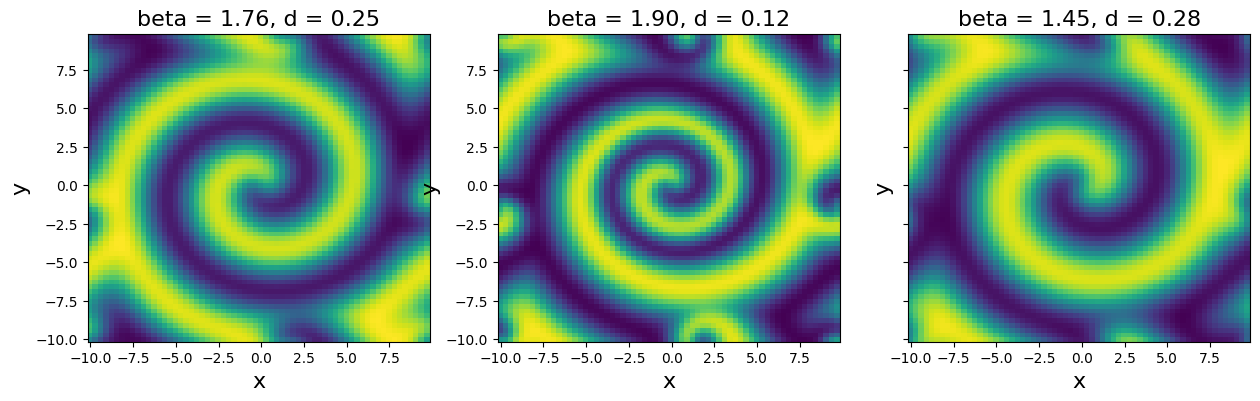

In [6]:
#Visual data 
#for i in range(0, 3, 1):
#    plot_data(X[i], y[i])
#    plt.show()
y_plot = y.reshape(-1, n, n)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.pcolor(X_grid, Y_grid, y_plot[0])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title(f'beta = {X[0][0]:.2f}, d = {X[0][1]:.2f}', fontsize=16)
plt.subplot(1, 3, 2)
plt.pcolor(X_grid, Y_grid, y_plot[1])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title(f'beta = {X[1][0]:.2f}, d = {X[1][1]:.2f}', fontsize=16)
plt.subplot(1, 3, 3)
plt.pcolor(X_grid, Y_grid, y_plot[2])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title(f'beta = {X[2][0]:.2f}, d = {X[2][1]:.2f}', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])


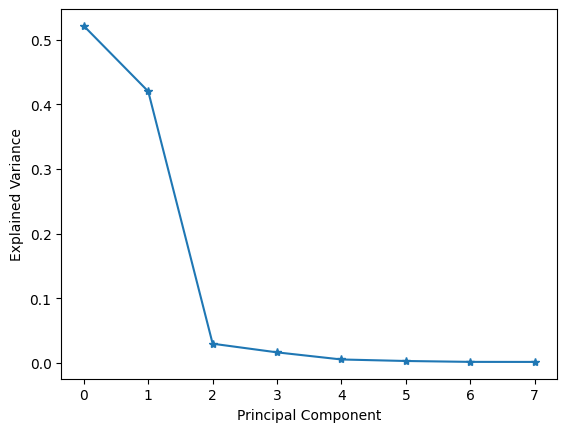

(90, 8)


In [7]:
# Perform PCA on the output data
from sklearn.decomposition import PCA

pca = PCA(n_components=8)
y_pca = pca.fit_transform(y)

# Plot the explained variance
plt.plot(pca.explained_variance_ratio_,'*-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

print(y_pca.shape)

# Plot the PCA
#plt.scatter(y_pca[:,0], y_pca[:,1])
#plt.show()

In [8]:
## AUTOEMULATE
# inputs are standardised (scale = True)
# 5-fold cross-validation
from sklearn.model_selection import KFold

em = AutoEmulate()
em.setup(X, y_pca, models=['gp'])#,  cross_validator=kfold)
best_model = em.compare()

,Values
Simulation input shape (X),"(90, 2)"
Simulation output shape (y),"(90, 8)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Do hyperparameter search (param_search),False
Reduce dimensionality (reduce_dim),False
Cross validator (cross_validator),KFold
Parallel jobs (n_jobs),1


Initializing:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
em.summarise_cv()

,model,short,rmse,r2
0,GaussianProcess,gp,0.696559,0.973609


In [10]:
#look at each of the cv-folds for a specific model, like GP
em.summarise_cv(model='GaussianProcess')

,fold,rmse,r2
0,0,0.515807,0.994452
1,1,1.281913,0.938666
2,2,0.612991,0.974183
3,3,0.671706,0.977157
4,4,0.400376,0.983586


Plotting the output variable with index 0. 
To plot other outputs, set `output_index` argument to the desired index.
Plotting the output variable with index 2. 
To plot other outputs, set `output_index` argument to the desired index.


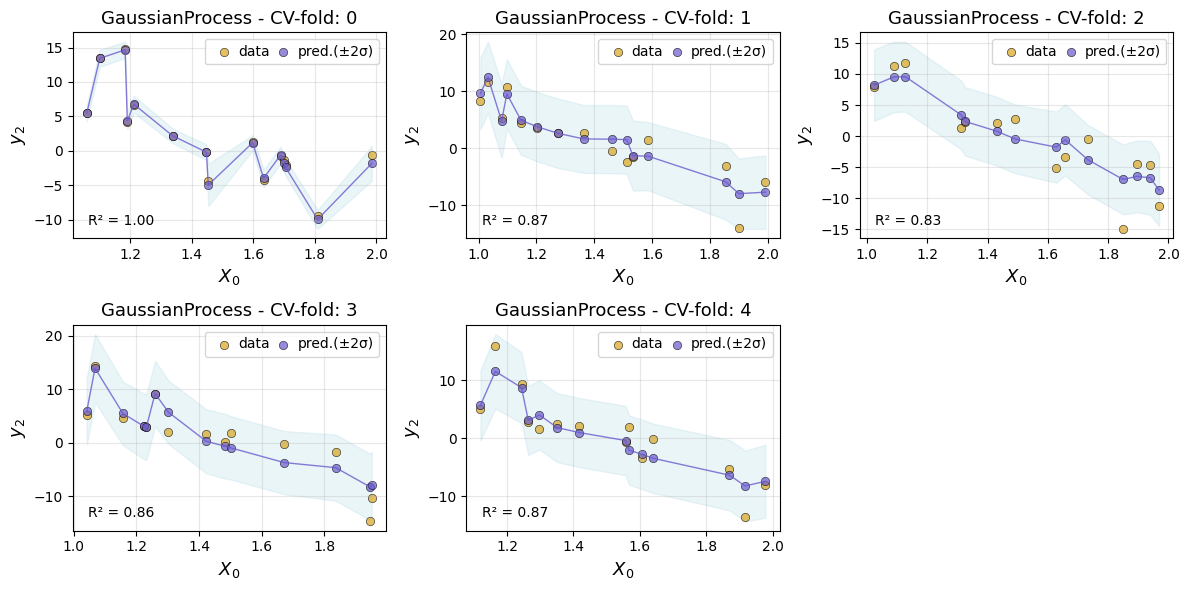

In [11]:
# To inspect spceific models more closely, we can plot the predictions for each cv fold for a given model

# Performance in predicting the first PCA component wrt first parameter (reaction beta)
PCA_component = 0
em.plot_cv(model='GaussianProcess', input_index=0, output_index=PCA_component)

# Performance in predicting the third PCA component wrt first parameter (reaction beta)
PCA_component = 2
em.plot_cv(model='GaussianProcess', input_index=0, output_index=PCA_component)


Plotting the output variable with index 0. 
To plot other outputs, set `output_index` argument to the desired index.


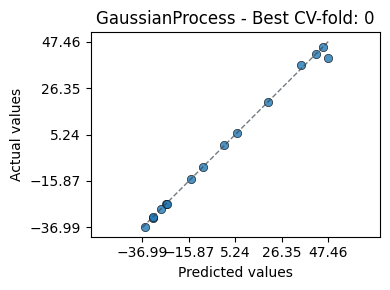

In [12]:
em.plot_cv(style="actual_vs_predicted")

Plotting the output variable with index 0. 
To plot other outputs, set `output_index` argument to the desired index.


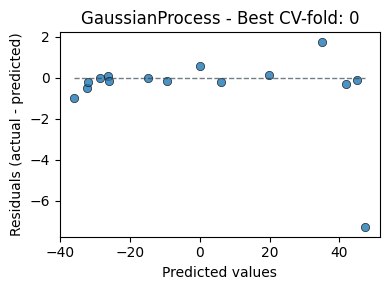

In [13]:
#Inspect the residuals too to spot any patterns
em.plot_cv(style="residual_vs_predicted")

In [14]:
## 3) Evaluate the emulator (on the test set)
gp = em.get_model('GaussianProcess')
em.evaluate(gp)

,model,short,rmse,r2
0,GaussianProcess,gp,0.6597,0.9441


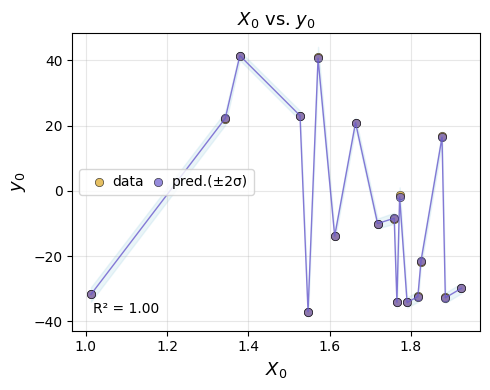

In [15]:
em.plot_eval(gp, input_index=0, output_index=0)

In [16]:
## 4) Refit the emulator model on the full data
gp_final = em.refit(gp)

## Prediction on the test set

In [17]:
# Predict on the test set
y_pred_pca = gp_final.predict(x_test)

# Reconstruction of the original data
y_pred = pca.inverse_transform(y_pred_pca)

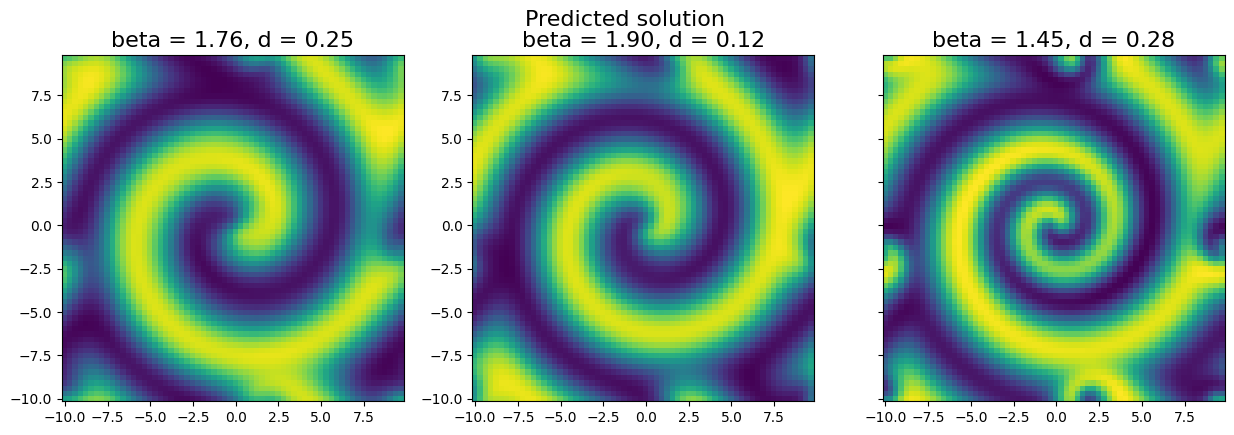

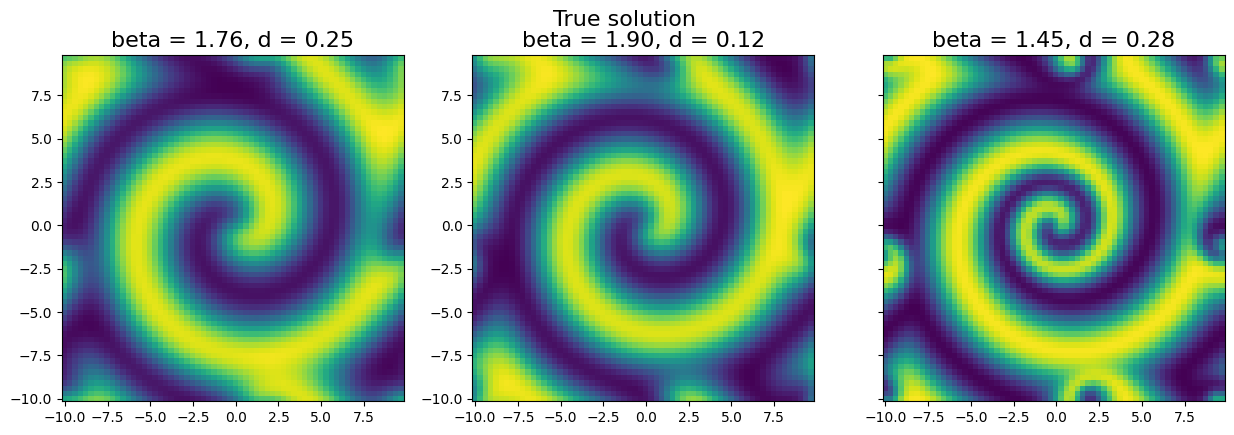

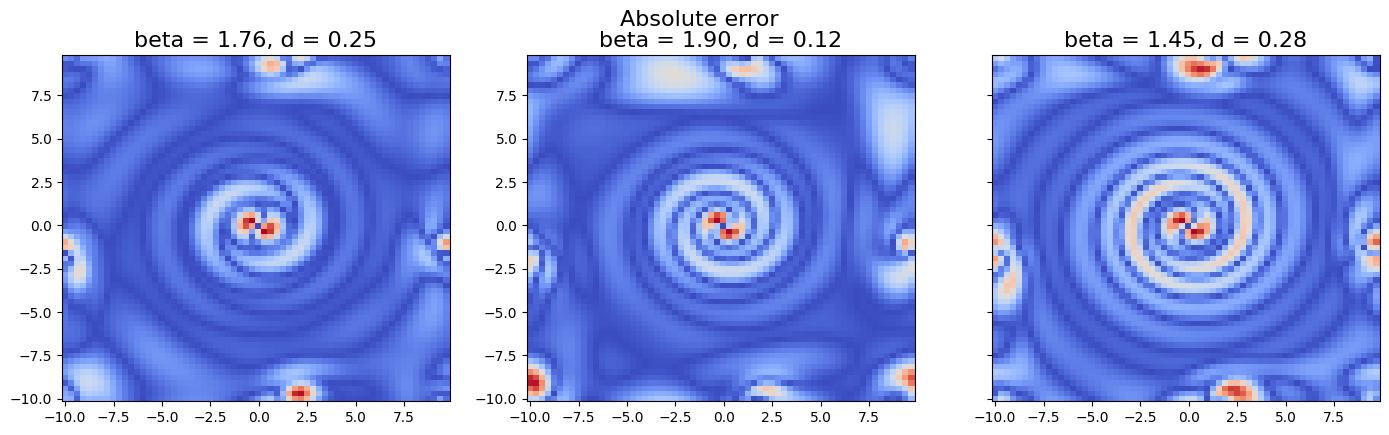

In [18]:
y_pred_plot = y_pred.reshape(-1, n, n)
y_test_plot = y_test.reshape(-1, n, n)

# Predicted solution
plt.figure(figsize=(15, 4.5))
plt.subplot(1, 3, 1)
plt.pcolor(X_grid, Y_grid, y_pred_plot[0])
plt.title(f'beta = {X[0][0]:.2f}, d = {X[0][1]:.2f}', fontsize=16)
plt.subplot(1, 3, 2)
plt.pcolor(X_grid, Y_grid, y_pred_plot[1])
plt.title(f'beta = {X[1][0]:.2f}, d = {X[1][1]:.2f}', fontsize=16)
plt.subplot(1, 3, 3)
plt.pcolor(X_grid, Y_grid, y_pred_plot[2])
plt.title(f'beta = {X[2][0]:.2f}, d = {X[2][1]:.2f}', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
# add overall title for the figure
plt.suptitle('Predicted solution\n', fontsize=16)
plt.show()

# True solution
plt.figure(figsize=(15, 4.5))
plt.subplot(1, 3, 1)
plt.pcolor(X_grid, Y_grid, y_test_plot[0])
plt.title(f'beta = {X[0][0]:.2f}, d = {X[0][1]:.2f}', fontsize=16)
plt.subplot(1, 3, 2)
plt.pcolor(X_grid, Y_grid, y_test_plot[1])
plt.title(f'beta = {X[1][0]:.2f}, d = {X[1][1]:.2f}', fontsize=16)
plt.subplot(1, 3, 3)
plt.pcolor(X_grid, Y_grid, y_test_plot[2])
plt.title(f'beta = {X[2][0]:.2f}, d = {X[2][1]:.2f}', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.suptitle('True solution\n', fontsize=16)
plt.show()

# Absolute error
plt.figure(figsize=(17, 4.5))
plt.subplot(1, 3, 1)
plt.pcolor(X_grid, Y_grid, np.abs(y_test_plot[0] - y_pred_plot[0]), cmap='coolwarm')
plt.title(f'beta = {X[0][0]:.2f}, d = {X[0][1]:.2f}', fontsize=16)
plt.subplot(1, 3, 2)
plt.pcolor(X_grid, Y_grid, np.abs(y_test_plot[1] - y_pred_plot[1]), cmap='coolwarm')
plt.title(f'beta = {X[1][0]:.2f}, d = {X[1][1]:.2f}', fontsize=16)
plt.subplot(1, 3, 3)
plt.pcolor(X_grid, Y_grid, np.abs(y_test_plot[2] - y_pred_plot[2]), cmap='coolwarm')
plt.title(f'beta = {X[2][0]:.2f}, d = {X[2][1]:.2f}', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
#add a color bar which doesnt shrink the last plot)
plt.suptitle('Absolute error\n', fontsize=16)
plt.show()
